In [1]:
import imageio.v2 as imageio
import torch
import os
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch import nn
import pandas as pd
from PIL import Image
from IPython.display import display, Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA

In [2]:
train_path = '/kaggle/input/butterfly-images40-species/train'
valid_path = '/kaggle/input/butterfly-images40-species/valid'
test_path = '/kaggle/input/butterfly-images40-species/test'

In [3]:
for path, dir_list, file_list in os.walk(train_path):
    print(f'Class - {path.split("/")[-1]}')
    print(f' -- Number of files {len(file_list)}')

Class - train
 -- Number of files 0
Class - PIPEVINE SWALLOW
 -- Number of files 119
Class - ARCIGERA FLOWER MOTH
 -- Number of files 140
Class - SIXSPOT BURNET MOTH
 -- Number of files 100
Class - ATLAS MOTH
 -- Number of files 129
Class - GREY HAIRSTREAK
 -- Number of files 123
Class - MALACHITE
 -- Number of files 103
Class - POPINJAY
 -- Number of files 121
Class - CABBAGE WHITE
 -- Number of files 127
Class - EASTERN DAPPLE WHITE
 -- Number of files 132
Class - AFRICAN GIANT SWALLOWTAIL
 -- Number of files 107
Class - MESTRA
 -- Number of files 120
Class - BIRD CHERRY ERMINE MOTH
 -- Number of files 133
Class - COPPER TAIL
 -- Number of files 133
Class - OLEANDER HAWK MOTH
 -- Number of files 132
Class - ORANGE OAKLEAF
 -- Number of files 125
Class - ORANGE TIP
 -- Number of files 137
Class - SOUTHERN DOGFACE
 -- Number of files 119
Class - EMPEROR GUM MOTH
 -- Number of files 136
Class - AMERICAN SNOOT
 -- Number of files 105
Class - CRIMSON PATCH
 -- Number of files 103
Class - 

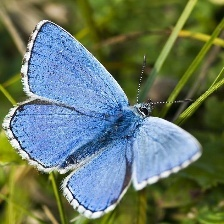

In [4]:
display(Image(filename=r'/kaggle/input/butterfly-images40-species/train/ADONIS/003.jpg'))

In [5]:
def number_of_files(path):
    counter = 0
    for _, _, file_list in os.walk(path):
        counter += len(file_list)
    print('Number of files:', counter)

In [6]:
number_of_files(train_path),number_of_files(valid_path),  number_of_files(test_path)

Number of files: 12594
Number of files: 500
Number of files: 500


(None, None, None)

# AUGMENTATION

In [7]:
aug1_transform =  A.Compose(
    [
        A.RandomRotate90(always_apply=True),
        A.CoarseDropout(max_width=30, max_height=30, always_apply = True),
        A.Defocus(always_apply = True)
    ])

In [8]:
aug2_transform =  A.Compose(
    [
        A.Downscale(always_apply=True),
        A.Spatter(always_apply = True),
        A.VerticalFlip(always_apply=True)
    ])

**Vizulation**

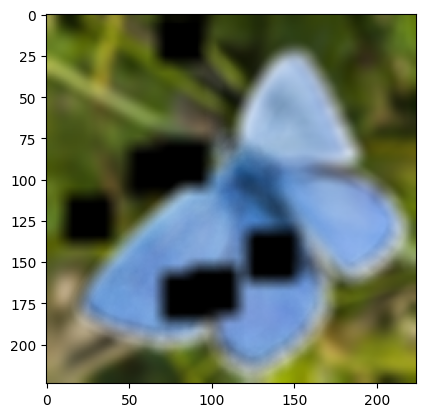

In [9]:
plt.imshow(aug1_transform(image = imageio.imread(os.path.join(r'/kaggle/input/butterfly-images40-species/train/ADONIS/003.jpg')))["image"])

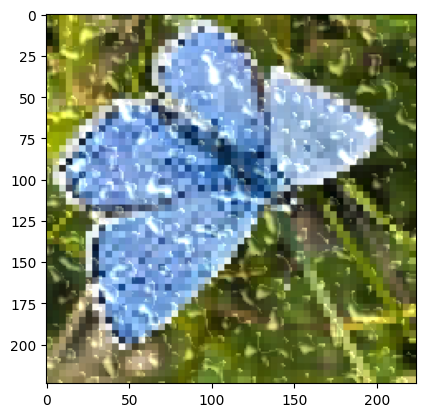

In [28]:
plt.imshow(aug2_transform(image = imageio.imread(os.path.join(r'/kaggle/input/butterfly-images40-species/train/ADONIS/003.jpg')))["image"]);

# Preprocessing

In [29]:
transform = v2.Compose(
          [  v2.ToImage(),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(mean = (0.485, 0.456, 0.406),
                       std =  (0.229, 0.224, 0.225))]
)

# Dateset


In [30]:
class CustomDataset(Dataset):
    def __init__(self, path_, transform_=None, aug = None):
        self.path_ = path_
        self.transform_ = transform_
        self.aug = aug
        self.data_list = []
        self.len_dataset = 0

        for path_dir, dir_list, file_list in os.walk(path_):
          if path_dir == path_:
            self.classes = dir_list
            self.index_of_class = { cls : i for i, cls in enumerate(sorted(self.classes))}
            continue

          cls = path_dir.split('/')[-1]
          for name_file in [i for i in file_list if ' ' not in i]:
            file_path = os.path.join(path_dir, name_file)
            self.data_list.append((file_path, self.index_of_class[cls]))
          self.len_dataset += len([i for i in file_list if ' ' not in i])
    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        file_path, label = self.data_list[idx]
        data = imageio.imread(file_path)
        if self.aug is not None:
            data = self.aug(image=data)["image"]
        if self.transform_ is not None:
            data = self.transform_(data)
        return data, label


In [31]:
train_data = CustomDataset(
    path_=train_path,
    transform_ = transform
    
)
train_agg1_data = CustomDataset(
    path_=train_path,
    transform_ = transform,
    aug = aug1_transform
    
)
train_agg2_data = CustomDataset(
    path_=train_path,
    transform_ = transform,
    aug = aug2_transform
    
)

In [32]:
train_data = torch.utils.data.ConcatDataset([train_agg1_data, train_data])
train_data = torch.utils.data.ConcatDataset([train_agg2_data, train_data])

In [33]:
len(train_data)

37782

In [34]:
valid_data = CustomDataset(
    path_=valid_path,
    transform_ = transform 
)

In [35]:
test_data = CustomDataset(
    path_=test_path,
    transform_ = transform
)

ZEBRA LONG WING


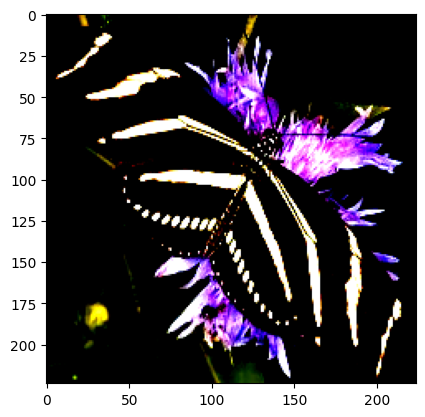

In [36]:
print(sorted(test_data.classes)[test_data[117][1]])
plt.imshow(np.array(test_data[117][0].permute(1, 2, 0)));

# DataLoader

In [37]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [38]:
for i, (samples, target)  in enumerate(train_loader):
    if i < 3:
        print(f'{i + 1}')
        print(f'{samples.shape}')
        print(f'{target.shape}')

print(f'Number of butches: {i + 1}')


1
torch.Size([16, 3, 224, 224])
torch.Size([16])
2
torch.Size([16, 3, 224, 224])
torch.Size([16])
3
torch.Size([16, 3, 224, 224])
torch.Size([16])
Number of butches: 2362


# MODEL

In [39]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [40]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [41]:
model.fc = torch.nn.Linear(model.fc.in_features, 100)

In [42]:
print(model.fc)

Linear(in_features=1024, out_features=100, bias=True)


In [43]:
model = model.to('cuda:0')

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5, weight_decay=4e-5)

In [45]:
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model.forward(inputs.to('cuda:0'))
        loss = criterion(outputs, labels.to('cuda:0'))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    valid_loss = 0.0
    model.eval()
    for data, labels in valid_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}', end= ' ')
    print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss / len(valid_loader)}')

Epoch 1, Train Loss: 2.6910155647695317 Epoch 1, Valid Loss: 0.03849507123231888
Epoch 3, Train Loss: 0.5010986767873281 Epoch 3, Valid Loss: 0.028786364942789078
Epoch 4, Train Loss: 0.36350651465239636 Epoch 4, Valid Loss: 0.005953957326710224
Epoch 5, Train Loss: 0.28768128826331024 Epoch 5, Valid Loss: 0.00027221575146541
Epoch 6, Train Loss: 0.23129964217537294 Epoch 6, Valid Loss: 0.0016540803480893373
Epoch 7, Train Loss: 0.19789413571875042 Epoch 7, Valid Loss: 0.001236829673871398
Epoch 8, Train Loss: 0.1693156085173843 Epoch 8, Valid Loss: 7.235851080622524e-05
Epoch 9, Train Loss: 0.15038749255724157 Epoch 9, Valid Loss: 0.3633003234863281
Epoch 10, Train Loss: 0.13461963034435637 Epoch 10, Valid Loss: 0.004025273025035858


In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        
print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the test set: 98.00%
